In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from datetime import datetime
import sys
import seaborn as sns
sns.set(style="darkgrid")

#local
BASE_PATH = "/content/drive/My Drive/collab/"
BASE_PATH = "/Users/samir/Dev/projects/MIMIC/"
sys.path.append(BASE_PATH+"TADAT/")

from tadat.pipeline import plots
from tadat.core import data, vectorizer, features, helpers, embeddings

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
raw_data_path = "/Users/samir/Dev/resources/datasets/MIMIC/full/"
out_data_path = BASE_PATH+"/MIMIC/DATA/input/"

## Read Data

In [26]:
df_mortality = pd.read_csv(out_data_path+"mini_mortality_balanced.csv",sep="\t", header=None, names=["EXPIRE","TEXT","GENDER","ETHNICITY_LABEL","ETHNICITY_BINARY"])
df_mortality 

,EXPIRE,TEXT,GENDER,ETHNICITY_LABEL,ETHNICITY_BINARY
0,0,admission date: [**2149-6-2**] discharg...,F,BLACK,NON-WHITE
1,0,admission date: [**2149-9-2**] discharg...,F,OTHER,OTHER
2,0,admission date: [**2193-1-8**] d...,M,BLACK,NON-WHITE
3,0,admission date: [**2133-9-3**] d...,M,OTHER,OTHER
4,0,admission date: [**2103-8-16**] discharge...,F,HISPANIC,NON-WHITE
...,...,...,...,...,...
1997,1,admission date: [**2190-5-22**] ...,M,OTHER,OTHER
1998,1,admission date: [**2118-7-29**] ...,F,OTHER,OTHER
1999,1,admission date: [**2114-5-24**] dischar...,F,WHITE,WHITE
2000,1,admission date: [**2152-9-22**] ...,F,OTHER,OTHER


In [27]:
df_mortality.groupby("GENDER").size()

GENDER
F     858
M    1144
dtype: int64

In [28]:
df_mortality.groupby("GENDER").size()

GENDER
F     858
M    1144
dtype: int64

In [29]:
df_readmission = pd.read_csv(out_data_path+"mini_readmissions_balanced.csv",sep="\t", header=None, names=["READMISSION","TEXT","GENDER","ETHNICITY_LABEL","ETHNICITY_BINARY"])
df_readmission

,READMISSION,TEXT,GENDER,ETHNICITY_LABEL,ETHNICITY_BINARY
0,0,admission date: [**2149-9-2**] discharg...,F,OTHER,OTHER
1,0,admission date: [**2193-1-8**] d...,M,BLACK,NON-WHITE
2,0,admission date: [**2103-8-16**] discharge...,F,HISPANIC,NON-WHITE
3,0,admission date: [**2196-4-27**] discharge...,M,OTHER,OTHER
4,0,admission date: [**2158-1-5**] d...,F,OTHER,OTHER
...,...,...,...,...,...
3387,1,admission date: [**2175-6-2**] discharge ...,M,NaN,NaN
3388,1,admission date: [**2148-4-4**] d...,F,NaN,NaN
3389,1,admission date: [**2135-4-10**] ...,F,NaN,NaN
3390,1,admission date: [**2183-5-9**] d...,M,NaN,NaN


In [30]:
df_readmission.groupby("GENDER").size()

GENDER
F    1477
M    1915
dtype: int64

In [31]:
df_readmission.groupby("GENDER").size()

GENDER
F    1477
M    1915
dtype: int64

## Analytics

In [35]:
def vectorize_data(train_split, test_split_M, test_split_F):
    #vectorize instances
    train_X = data.getX(train_split)
    test_X_M = data.getX(test_split_M)
    test_X_F = data.getX(test_split_F)
    
    train_X, word_vocab = vectorizer.docs2idx(train_X)
    test_X_M,_ = vectorizer.docs2idx(test_X_M, word_vocab)
    test_X_F,_ = vectorizer.docs2idx(test_X_F, word_vocab)
    #vectorize labels
    train_Y = data.getY(train_split)
    test_Y_M = data.getY(test_split_M) 
    test_Y_F = data.getY(test_split_F)    
    label_vocab = vectorizer.get_labels_vocab(train_Y+test_Y_M+test_Y_F)
    train_Y,_ = vectorizer.label2idx(train_Y, label_vocab)
    test_Y_M,_ = vectorizer.label2idx(test_Y_M, label_vocab)
    test_Y_F,_ = vectorizer.label2idx(test_Y_F, label_vocab)
    
    return train_X, train_Y, test_X_M, test_Y_M, test_X_F, test_Y_F, word_vocab, label_vocab

def get_features(data, vocab_size, feature_type, word_vectors=None):
    if feature_type == "BOW-bin":
        X = features.BOW(data, vocab_size,sparse=True)
    elif feature_type == "BOW-freq":
        X = features.BOW_freq(data, vocab_size,sparse=True)
    elif feature_type == "BOE-bin":
        X = features.BOE(data, word_vectors,"bin")
    elif feature_type == "BOE-sum": 
        X = features.BOE(data, word_vectors,"sum")
    else:
        raise NotImplementedError
    return X
    
def get_BERT_embedding(X):
    X_cls, X_pool =  embeddings.transformer_encode_batches(X, batchsize=50)
    return X_cls, X_pool
    
    
def evaluate_classifier(X_train, Y_train, X_test, Y_test,
                   labels, model_name, random_seed=1234, res_path=None):
    model = SGDClassifier(random_state=random_seed)
    model.fit(X_train,Y_train)
    Y_hat = model.predict(X_test)
    microF1 = f1_score(Y_test, Y_hat, average="micro") 
    macroF1 = f1_score(Y_test, Y_hat, average="macro") 
    acc = accuracy_score(Y_test, Y_hat)
    precision, recall, fscore, support = score(Y_test, Y_hat)

    res = {"model":model_name, \
            "seed":random_seed, \
            "acc":round(acc,3), \
            "microF1":round(microF1,3), \
            "macroF1":round(macroF1,3)
            }

    for l, i in labels.items():
        try:
            fs = round(fscore[i],3)
        except IndexError:
            fs = 0
        res["{}-f1".format(l)] = fs
#     helpers.print_results(res)
    if res_path is not None:
        cols = ["dataset", "model", "acc", "avgF1"]
        # helpers.save_results(res, res_path, sep="\t", columns=cols)
        helpers.save_results(res, res_path, sep="\t")
    return res

def get_deltas(results_M, results_F):
    #resuts
    df_M = pd.DataFrame(results_M)
    df_F = pd.DataFrame(results_F)
    #compute deltas
    df_delta = df_M.sub(df_F.iloc[:,2:])
    df_delta["model"] = df_M["model"]
    df_delta["seed"] = df_M["seed"]   
    return df_delta

def run(df, x_label, y_label, feature_type, target_label, target_value, split=0.8):
    #split into training and test sets
    train_split, test_split = data.shuffle_split_idx(df[y_label], split)
    df_train = df.iloc[train_split,:]
    df_test = df.iloc[test_split,:]
    df_test_M = df_test[df_test[target_label] == target_value]
    df_test_F = df_test[df_test[target_label] != target_value]
    
    print("M: {} | F: {}".format(len(df_test_M),len(df_test_F)))
    #transform the data into the right format
    train = data.read_dataframe(df_train, x_label, y_label)
    test_M = data.read_dataframe(df_test_M, x_label, y_label)
    test_F = data.read_dataframe(df_test_F, x_label, y_label)
    #get vectorized train/test data 
    train_X, train_Y, test_X_M, test_Y_M, test_X_F, test_Y_F, word_vocab, label_vocab = vectorize_data(train, test_M, test_F)
    
    if "BOW" in feature_type:
        #extract features
        train_feats = get_features(train_X, len(word_vocab), feature_type)
        test_feats_M = get_features(test_X_M, len(word_vocab), feature_type)
        test_feats_F = get_features(test_X_F, len(word_vocab), feature_type)
    elif "BERT" == feature_type:
        train_feats = get_BERT_embedding(train)
        test_feats_M = get_BERT_embedding(test_M)
        test_feats_F = get_BERT_embedding(test_F)
    else:
        raise NotImplementedError
    
    label_vocab = vectorizer.get_labels_vocab(train_Y+test_Y_M+test_Y_F)
    #train/test classifier for each random seed
    random_seeds = list(range(20))
    results_m = []
    results_f = []
    for r in random_seeds:
        print("[running seed: {}]".format(r))
        res_m = evaluate_classifier(train_feats, train_Y, test_feats_M, test_Y_M, label_vocab, feature_type, r)
        results_m.append(res_m)
        res_f = evaluate_classifier(train_feats, train_Y, test_feats_F, test_Y_F, label_vocab, feature_type, r)
        results_f.append(res_f)
    return results_m, results_f



# Analyses

In [43]:
def outcome_anaylsis(df, x_label, y_label, feature_type):
    
    results_M, results_F = run(df, x_label, y_label, feature_type, "GENDER", "M", split=0.8)
    df_delta = get_deltas(results_M,results_F)
    
    return df_delta
    
    
def plot_performance(df_delta, title, LIM):
    #plots
    fig, ax = plt.subplots(1,1, sharey=True, figsize=(18,5))
    plots.plot_df(df=df_delta,ax=ax,x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
    ax.set_title("Gender")
    ax.legend(loc='best')
    fig.suptitle(title ,y=1.01)

def plot_catplot(df_delta, title, LIM):
    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model"], value_vars=["microF1","0-f1","1-f1"], 
                                        var_name="metric", value_name="delta")

    g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long, sharey=True,legend_out=True)
    ax = g.axes[0]
    ax[0].axhline(0, ls='--',c="r")
    ax[0].set_ylim([-LIM,LIM])    
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()  


In [51]:
df_bert_delta = outcome_anaylsis(df_mortality,"TEXT","EXPIRE", "BERT")
df_bert_delta

M: 240 | F: 162


KeyboardInterrupt: 

## mortality 

In [44]:
df_bb_delta = outcome_anaylsis(df_mortality,"TEXT","EXPIRE", "BOW-bin")
df_bf_delta = outcome_anaylsis(df_mortality,"TEXT","EXPIRE", "BOW-freq")


M: 240 | F: 162


/Users/samir/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/samir/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/Users/samir/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
[running seed: 1]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[running seed: 2]
[running seed: 3]
[running seed: 4]
[running seed: 5]
[running seed: 6]
[running seed: 7]
[running seed: 8]
[running seed: 9]
[running seed: 10]
[running seed: 11]
[running seed: 12]
[running seed: 13]
[running seed: 14]
[running seed: 15]
[running seed: 16]
[running seed: 17]
[running seed: 18]
[running seed: 19]
M: 240 | F: 162
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
[running seed: 1]
[running seed: 2]
[running seed: 3]
[running seed: 4]
[running seed: 5]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

[running seed: 6]
[running seed: 7]
[running seed: 8]
[running seed: 9]
[running seed: 10]
[running seed: 11]
[running seed: 12]
[running seed: 13]
[running seed: 14]
[running seed: 15]
[running seed: 16]
[running seed: 17]
[running seed: 18]
[running seed: 19]


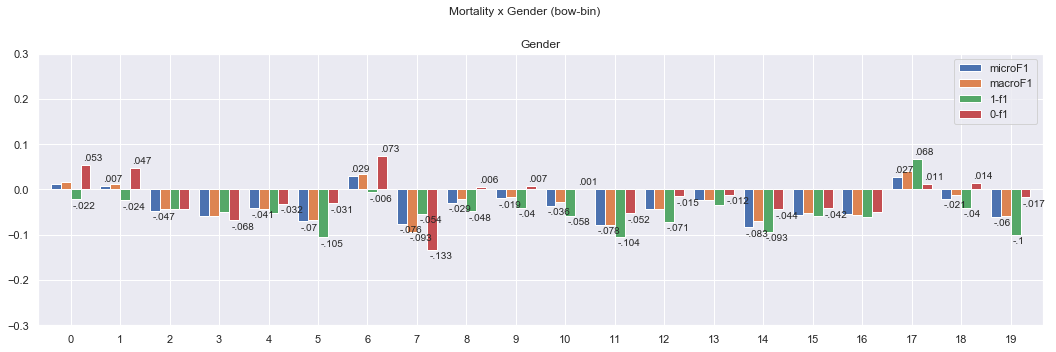

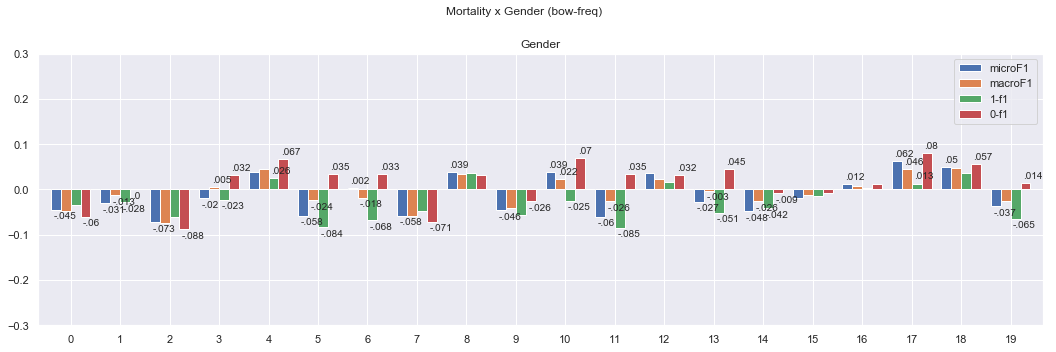

In [45]:
LIM = 0.3
plot_performance(df_bb_delta, "Mortality x Gender (bow-bin)", LIM)
plot_performance(df_bf_delta, "Mortality x Gender (bow-freq)", LIM)

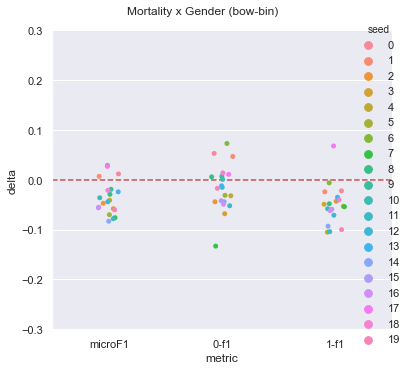

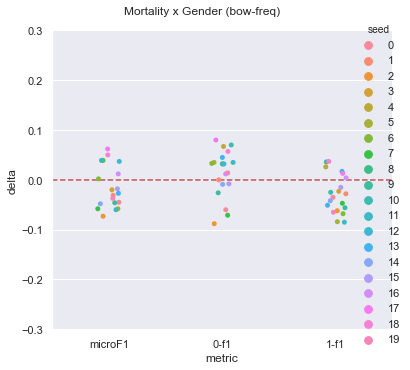

In [46]:
plot_catplot(df_bb_delta, "Mortality x Gender (bow-bin)", LIM)
plot_catplot(df_bf_delta, "Mortality x Gender (bow-freq)", LIM)


## readmissions


In [47]:
df_rea_bb_delta = outcome_anaylsis(df_readmission,"TEXT","READMISSION", "BOW-bin")
df_rea_bf_delta = outcome_anaylsis(df_readmission,"TEXT","READMISSION", "BOW-freq")


M: 382 | F: 298


/Users/samir/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/samir/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/Users/samir/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
[running seed: 1]
[running seed: 2]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[running seed: 3]
[running seed: 4]
[running seed: 5]
[running seed: 6]
[running seed: 7]
[running seed: 8]
[running seed: 9]
[running seed: 10]
[running seed: 11]
[running seed: 12]
[running seed: 13]
[running seed: 14]
[running seed: 15]
[running seed: 16]
[running seed: 17]
[running seed: 18]
[running seed: 19]
M: 382 | F: 298
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
[running seed: 1]
[running seed: 2]
[running seed: 3]
[running seed: 4]
[running seed: 5]
[running seed: 6]
[running seed: 7]
[running seed: 8]
[running seed: 9]
[running seed: 10]
[running seed: 11]
[running seed: 12]
[running seed: 13]
[running seed: 14]
[running seed: 15]
[running seed: 16]
[running seed: 17]
[running seed: 18]
[running seed: 19]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

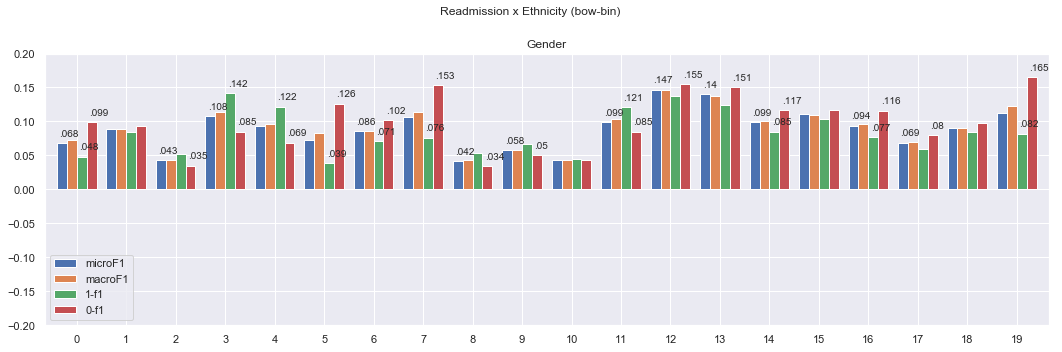

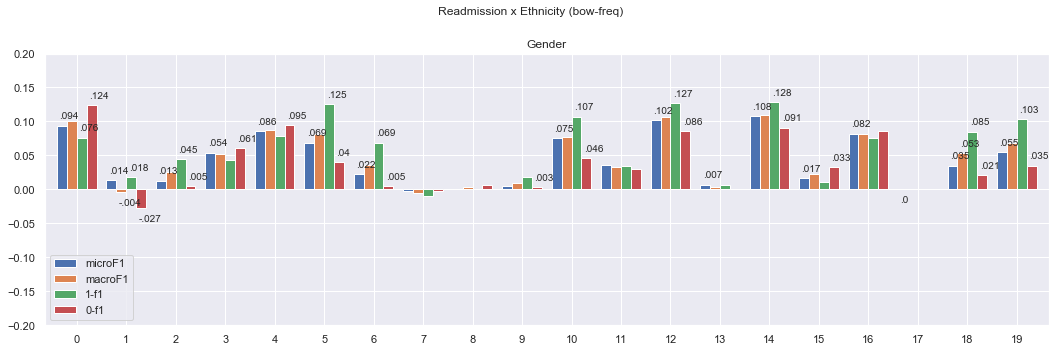

In [48]:
LIM = 0.2
plot_performance(df_rea_bb_delta, "Readmission x Ethnicity (bow-bin)", LIM)
plot_performance(df_rea_bf_delta, "Readmission x Ethnicity (bow-freq)",LIM)

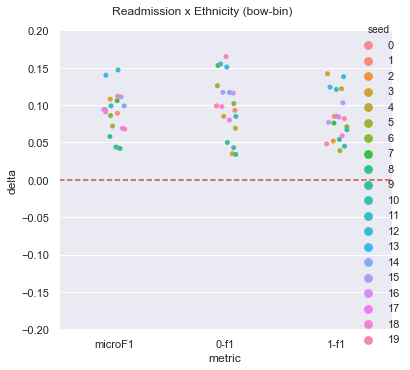

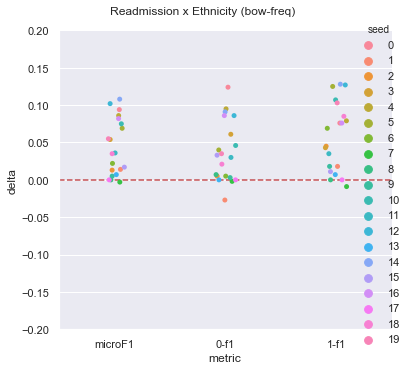

In [49]:
plot_catplot(df_rea_bb_delta, "Readmission x Ethnicity (bow-bin)", LIM)
plot_catplot(df_rea_bf_delta, "Readmission x Ethnicity (bow-freq)", LIM)
